In [3]:
# ============================================================
# PHASE 5: Full pipeline + exports + plots + variable importance
# - preprocessing + tuning + best-model selection
# - ROC/AUC plot, Confusion Matrix plot, Calibration plot
# - export metrics + best params + variable importance (best model)
# - export VERO scores WITH patient_id (patient_id never enters modeling)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix
)

# ----------------------------
# 0) Paths
# ----------------------------
OUT_DIR = "phase5_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 1) Load data
# ----------------------------
try:
    death
except NameError:
    death = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\Phase 3\merged_with_phenotypes\death_with_phenotype.csv")

death.columns = [c.strip() for c in death.columns]

TARGET_COL = "phenotype"

# Locked drops (kept for documentation; we do NOT include them in FEATURE_COLS anyway)
DROP_COLS = [
    "patient_id",
    "death_outcome",
    "survival_days",
    "end_due_to_progression",
    "end_reason_progression_any_line",
    "end_reason_other_any_line",
    "chemio_fine_tossicita",
    "adr_description",
    "adr_n_grado1", "adr_n_grado2", "adr_n_grado3", "adr_n_grado4", "adr_n_grado5",
]

# Frozen Phase 5 feature list (as agreed)
FEATURE_COLS = [
    # Demographics & Socio-economic
    "age", "age_group", "gender", "ethnicity", "education_level",
    "employment_status", "alcohol_consumption", "smoking_status_detail",

    # Tumor & Molecular Context
    "tumor_type", "molecular_alterations", "mutations_present", "genotipo_DPYD_type",

    # Treatment Exposure (Baseline)
    "surgical_intervention", "radiotherapy_status", "received_chemo", "received_targeted_therapy",
    "oncology_treatment_lines_n", "n_treatment_lines", "max_combo_regimen_size",
    "total_chemo_cycles", "treatment_duration_days",

    # Comorbidities & Clinical Conditions
    "hypertension", "dyslipidemia", "ischemic_heart_disease", "atrial_fibrillation",
    "hypertensive_heart_disease", "diabete_tipo_II", "obesity_comorbidity", "copd", "asthma",
    "renal_insufficiency", "anemia_comorbidity", "depressive_syndrome", "psychiatric_disorders",
    "cerebrovascular_disorders", "gastroesophageal_reflux_full", "gastrointestinal_disorders",
    "cardiovascular_disorders",

    # Frailty & Burden Indices
    "cci_score", "IPB", "farmaci_cat_n", "total_unique_active_drugs",

    # Laboratory Ranges
    "white_blood_cells_range", "red_blood_cells_range", "hemoglobin_range",
    "neutrophils_percent_range", "platelet_count_range", "creatinine_range",
    "ast_got_range", "alt_gpt_range", "total_bilirubin_range", "direct_bilirubin_range",

    # ADR Summary (single representation)
    "adr_n_tot",
]

# ----------------------------
# 2) Sanity checks + modeling frame (keep patient_id separately)
# ----------------------------
if "patient_id" not in death.columns:
    raise ValueError("patient_id not found in dataset (needed for score export).")

missing = [c for c in FEATURE_COLS if c not in death.columns]
if missing:
    raise ValueError("Missing frozen Phase 5 features:\n" + "\n".join(missing))

if TARGET_COL not in death.columns:
    raise ValueError(f"Missing target column: {TARGET_COL}")

# Build a working df including patient_id ONLY for later export
df = death[["patient_id"] + FEATURE_COLS + [TARGET_COL]].copy()

# Clean phenotype
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")
df = df[df[TARGET_COL].isin([0, 1])].copy()

# Enforce age_group labels exactly as specified
df["age_group"] = df["age_group"].astype(str).str.strip()
df = df[df["age_group"].isin(["<= 65 years", "> 65 years"])].copy()

# Reset index to keep alignment consistent downstream
df["patient_id"] = df["patient_id"].astype(str).str.strip()
df = df.reset_index(drop=True)

pid_all = df["patient_id"].copy()
X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(int).copy()

# ----------------------------
# 3) Train/test split (hold-out set)
# ----------------------------
X_train, X_test, y_train, y_test, pid_train, pid_test = train_test_split(
    X, y, pid_all,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Phenotype train distribution:\n", y_train.value_counts(normalize=True).round(3))

# ----------------------------
# 4) Preprocessors
# ----------------------------
numeric_cols = [c for c in FEATURE_COLS if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in FEATURE_COLS if c not in numeric_cols]

numeric_pipe_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

numeric_pipe_noscale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_scaled, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_noscale, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop"
)

# ----------------------------
# 5) Candidate models + tuning spaces
# ----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
candidates = []

# Logistic Regression (interpretable)
logreg = LogisticRegression(solver="saga", max_iter=5000, class_weight="balanced")
pipe_logreg = Pipeline(steps=[("preprocess", preprocessor_linear), ("model", logreg)])
param_logreg = {
    "model__penalty": ["l1", "l2", "elasticnet"],
    "model__C": np.logspace(-3, 2, 30),
    "model__l1_ratio": np.linspace(0.0, 1.0, 11),  # only used for elasticnet
}
candidates.append(("LogReg_ElasticNet", pipe_logreg, param_logreg, 80))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
pipe_rf = Pipeline(steps=[("preprocess", preprocessor_tree), ("model", rf)])
param_rf = {
    "model__n_estimators": [400, 600, 900, 1200],
    "model__max_depth": [None, 4, 6, 8, 12, 16],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5, 0.8],
}
candidates.append(("RandomForest", pipe_rf, param_rf, 60))

# HistGradientBoosting (sklearn)
hgb = HistGradientBoostingClassifier(random_state=42)
pipe_hgb = Pipeline(steps=[("preprocess", preprocessor_tree), ("model", hgb)])
param_hgb = {
    "model__learning_rate": np.linspace(0.02, 0.2, 10),
    "model__max_depth": [None, 2, 3, 4, 5, 6],
    "model__max_leaf_nodes": [15, 31, 63, 127],
    "model__min_samples_leaf": [10, 20, 30, 50, 80],
    "model__l2_regularization": [0.0, 0.1, 0.5, 1.0],
    "model__max_iter": [200, 400, 800],
}
candidates.append(("HistGB", pipe_hgb, param_hgb, 60))

# Optional: XGBoost if installed
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
    pipe_xgb = Pipeline(steps=[("preprocess", preprocessor_tree), ("model", xgb)])
    param_xgb = {
        "model__n_estimators": [300, 600, 900, 1200],
        "model__learning_rate": np.linspace(0.01, 0.2, 10),
        "model__max_depth": [2, 3, 4, 5, 6, 8],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0],
        "model__min_child_weight": [1, 3, 5, 10],
        "model__reg_lambda": [0.0, 0.5, 1.0, 2.0, 5.0],
    }
    candidates.append(("XGBoost", pipe_xgb, param_xgb, 60))
    print("XGBoost detected: included in candidate set.")
except Exception:
    print("XGBoost not available: proceeding with sklearn models only.")

# ----------------------------
# 6) Helpers: evaluation + plotting + feature names
# ----------------------------
def predict_scores(est, X_):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X_)[:, 1]
    if hasattr(est, "decision_function"):
        return est.decision_function(X_)
    raise ValueError("Estimator has neither predict_proba nor decision_function.")

def evaluate_binary(est, X_te, y_te, threshold=0.5):
    p = predict_scores(est, X_te)
    yhat = (p >= threshold).astype(int)
    cm = confusion_matrix(y_te, yhat)

    return {
        "auc": float(roc_auc_score(y_te, p)),
        "accuracy": float(accuracy_score(y_te, yhat)),
        "balanced_accuracy": float(balanced_accuracy_score(y_te, yhat)),
        "precision": float(precision_score(y_te, yhat, zero_division=0)),
        "recall": float(recall_score(y_te, yhat, zero_division=0)),
        "f1": float(f1_score(y_te, yhat, zero_division=0)),
        "threshold": float(threshold),
        "tn": int(cm[0, 0]), "fp": int(cm[0, 1]),
        "fn": int(cm[1, 0]), "tp": int(cm[1, 1]),
    }

def plot_roc(y_true, p_score, title, out_path):
    fpr, tpr, _ = roc_curve(y_true, p_score)
    auc_val = roc_auc_score(y_true, p_score)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title}\nAUC = {auc_val:.4f}")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

def plot_confusion_matrix(cm, title, out_path):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0", "Pred 1"])
    plt.yticks(tick_marks, ["True 0", "True 1"])

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

def plot_calibration(y_true, p_score, title, out_path, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, p_score, n_bins=n_bins, strategy="uniform")

    plt.figure(figsize=(7, 6))
    plt.plot(prob_pred, prob_true, marker="o", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Observed event rate")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

def get_pipeline_feature_names(fitted_pipeline):
    """
    Works for Pipeline(preprocess -> model) where preprocess is ColumnTransformer
    and categorical uses OneHotEncoder(sparse_output=False).
    """
    pre = fitted_pipeline.named_steps["preprocess"]
    feat_names = []

    # numeric
    num_cols = pre.transformers_[0][2]  # ("num", pipe, cols)
    feat_names.extend(list(num_cols))

    # categorical one-hot names
    cat_cols = pre.transformers_[1][2]  # ("cat", pipe, cols)
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(cat_cols)
    feat_names.extend(list(cat_names))

    return feat_names

def export_and_plot_importance(best_name, fitted_best_pipeline, out_dir, top_n=30):
    """
    Exports variable importance for:
    - LogisticRegression: absolute coefficients
    - RandomForest: feature_importances_
    - XGBoost: feature_importances_ (gain-like proxy from sklearn wrapper)
    - HistGB: permutation importance would be better, but keep simple here
    """
    model = fitted_best_pipeline.named_steps["model"]
    feature_names = get_pipeline_feature_names(fitted_best_pipeline)

    imp_df = None

    if hasattr(model, "coef_"):
        coef = model.coef_.ravel()
        imp_df = pd.DataFrame({
            "feature": feature_names,
            "importance": np.abs(coef),
            "signed_coef": coef
        }).sort_values("importance", ascending=False)

    elif hasattr(model, "feature_importances_"):
        fi = model.feature_importances_
        imp_df = pd.DataFrame({
            "feature": feature_names,
            "importance": fi
        }).sort_values("importance", ascending=False)

    else:
        # As a fallback, export nothing and warn.
        print(f"Note: importance not available for model type: {type(model)}")
        return None

    imp_csv = os.path.join(out_dir, f"phase5_importance_{best_name}.csv")
    imp_df.to_csv(imp_csv, index=False)
    print("Saved:", imp_csv)

    top = imp_df.head(top_n).copy()
    plt.figure(figsize=(10, 7))
    plt.barh(top["feature"][::-1], top["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Feature Importance - {best_name}")
    plt.tight_layout()
    imp_png = os.path.join(out_dir, f"phase5_importance_{best_name}_top{top_n}.png")
    plt.savefig(imp_png, dpi=300)
    plt.close()
    print("Saved:", imp_png)

    return imp_df

# ----------------------------
# 7) Tuning loop + summary exports
# ----------------------------
results_rows = []
best_models = {}
cv_results_slim = []

for name, pipe, param_dist, n_iter in candidates:
    print(f"\n=== Tuning: {name} ===")

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="roc_auc",
        n_jobs=-1,
        cv=cv,
        random_state=42,
        verbose=1,
        refit=True
    )
    search.fit(X_train, y_train)

    best_est = search.best_estimator_
    best_models[name] = best_est

    # Hold-out evaluation at threshold 0.5
    p_test = predict_scores(best_est, X_test)
    metrics = evaluate_binary(best_est, X_test, y_test, threshold=0.5)

    row = {
        "model": name,
        "cv_auc": float(search.best_score_),
        "test_auc": metrics["auc"],
        "test_accuracy": metrics["accuracy"],
        "test_balanced_accuracy": metrics["balanced_accuracy"],
        "test_precision": metrics["precision"],
        "test_recall": metrics["recall"],
        "test_f1": metrics["f1"],
        "threshold": metrics["threshold"],
        "tn": metrics["tn"], "fp": metrics["fp"], "fn": metrics["fn"], "tp": metrics["tp"],
        "best_params": str(search.best_params_)
    }
    results_rows.append(row)

    # save slim CV results for transparency (top 25 by mean_test_score)
    tmp = pd.DataFrame(search.cv_results_)
    keep_cols = [c for c in tmp.columns if c in ["mean_test_score", "std_test_score", "rank_test_score", "params"]]
    tmp = tmp[keep_cols].sort_values("rank_test_score").head(25).copy()
    tmp["model"] = name
    cv_results_slim.append(tmp)

# Export candidate performance summary
res_df = pd.DataFrame(results_rows).sort_values(by=["test_auc", "cv_auc"], ascending=False)
res_path = os.path.join(OUT_DIR, "phase5_candidate_model_results_expanded.csv")
res_df.to_csv(res_path, index=False)
print("\nSaved:", res_path)
print("\nTop models (test_auc, cv_auc):")
print(res_df[["model", "test_auc", "cv_auc", "test_balanced_accuracy", "test_accuracy", "test_precision", "test_recall", "test_f1"]].head(10))

# Export slim CV tables
cv_slim_df = pd.concat(cv_results_slim, ignore_index=True)
cv_slim_path = os.path.join(OUT_DIR, "phase5_cv_results_top25_each_model.csv")
cv_slim_df.to_csv(cv_slim_path, index=False)
print("Saved:", cv_slim_path)

# ----------------------------
# 8) Pick best model and CALIBRATE
# ----------------------------
best_name = res_df.iloc[0]["model"]
best_estimator = best_models[best_name]
print("\nBest selected model:", best_name)

# Calibrate on training only (CV inside calibrator)
calibrator = CalibratedClassifierCV(
    estimator=best_estimator,
    method="isotonic",   # switch to "sigmoid" if you suspect isotonic overfits
    cv=5
)
calibrator.fit(X_train, y_train)

# Evaluate calibrated model on test
p_test_cal = calibrator.predict_proba(X_test)[:, 1]
yhat_cal = (p_test_cal >= 0.5).astype(int)
cm_cal = confusion_matrix(y_test, yhat_cal)

cal_metrics = evaluate_binary(calibrator, X_test, y_test, threshold=0.5)
cal_metrics_row = {
    "best_base_model": best_name,
    **cal_metrics
}
cal_metrics_path = os.path.join(OUT_DIR, "phase5_best_model_calibrated_test_metrics.csv")
pd.DataFrame([cal_metrics_row]).to_csv(cal_metrics_path, index=False)
print("Saved:", cal_metrics_path)
print("Calibrated test AUC:", cal_metrics["auc"])

# ----------------------------
# 9) PLOTS: ROC, Confusion Matrix, Calibration curve
# ----------------------------
# (A) ROC (calibrated)
roc_path = os.path.join(OUT_DIR, f"phase5_roc_{best_name}_calibrated.png")
plot_roc(y_test, p_test_cal, title=f"ROC Curve - {best_name} (Calibrated)", out_path=roc_path)
print("Saved:", roc_path)

# (B) Confusion matrix (calibrated)
cm_path = os.path.join(OUT_DIR, f"phase5_confusion_matrix_{best_name}_calibrated.png")
plot_confusion_matrix(cm_cal, title=f"Confusion Matrix - {best_name} (Calibrated, thr=0.5)", out_path=cm_path)
print("Saved:", cm_path)

# (C) Calibration curve (calibrated)
cal_plot_path = os.path.join(OUT_DIR, f"phase5_calibration_{best_name}_calibrated.png")
plot_calibration(y_test, p_test_cal, title=f"Calibration Plot - {best_name} (Calibrated)", out_path=cal_plot_path, n_bins=10)
print("Saved:", cal_plot_path)

# ----------------------------
# 10) Variable importance for BEST BASE model (not calibrator wrapper)
#     Important: calibrator wraps estimator; interpret importance on base estimator.
# ----------------------------
imp_df = export_and_plot_importance(best_name, best_estimator, OUT_DIR, top_n=30)

# ----------------------------
# 11) Export VERO scores WITH patient_id (no leakage)
# ----------------------------
# Score = calibrated probability of phenotype=1 (Accelerated Aging / Frailty)
p_all = calibrator.predict_proba(X)[:, 1]
vero_index = np.rint(100 * p_all).astype(int)

# Optional: strata (initial cutpoints you defined)
def strata(score):
    if score <= 30:
        return "Low"
    if score <= 70:
        return "Medium"
    return "High"

vero_strata = [strata(s) for s in vero_index]

out_scores = pd.DataFrame({
    "patient_id": pid_all,  # safe here
    "phenotype_true": y.values,
    "vero_prob_calibrated": p_all,
    "vero_index_0_100": vero_index,
    "risk_strata_initial": vero_strata
})

scores_path = os.path.join(OUT_DIR, "phase5_vero_scores_all_patients_WITH_patient_id.csv")
out_scores.to_csv(scores_path, index=False)
print("Saved:", scores_path)

# ----------------------------
# 12) Print a compact report to console (human-readable)
# ----------------------------
print("\n==================== PHASE 5 SUMMARY ====================")
print("Best base model:", best_name)
print("Hold-out calibrated metrics (thr=0.5):")
for k in ["auc", "accuracy", "balanced_accuracy", "precision", "recall", "f1"]:
    print(f"  {k}: {cal_metrics[k]:.4f}")
print("Confusion matrix (TN FP / FN TP):")
print(f"  TN={cal_metrics['tn']}  FP={cal_metrics['fp']}")
print(f"  FN={cal_metrics['fn']}  TP={cal_metrics['tp']}")
print("Outputs folder:", os.path.abspath(OUT_DIR))
print("========================================================\n")


Train: (324, 53) Test: (82, 53)
Phenotype train distribution:
 phenotype
0    0.67
1    0.33
Name: proportion, dtype: float64
XGBoost detected: included in candidate set.

=== Tuning: LogReg_ElasticNet ===
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



=== Tuning: RandomForest ===
Fitting 5 folds for each of 60 candidates, totalling 300 fits

=== Tuning: HistGB ===
Fitting 5 folds for each of 60 candidates, totalling 300 fits

=== Tuning: XGBoost ===
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Saved: phase5_outputs\phase5_candidate_model_results_expanded.csv

Top models (test_auc, cv_auc):
               model  test_auc    cv_auc  test_balanced_accuracy  \
0  LogReg_ElasticNet  0.962290  0.924147                0.898990   
2             HistGB  0.889562  0.912745                0.751178   
3            XGBoost  0.882155  0.910375                0.705051   
1       RandomForest  0.839057  0.890713                0.723569   

   test_accuracy  test_precision  test_recall   test_f1  
0       0.902439        0.827586     0.888889  0.857143  
2       0.792683        0.708333     0.629630  0.666667  
3       0.756098        0.652174     0.555556  0.600000  
1       0.768293        0.666667     0.592593  0.627451  
Saved

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Saved: phase5_outputs\phase5_best_model_calibrated_test_metrics.csv
Calibrated test AUC: 0.9521885521885521
Saved: phase5_outputs\phase5_roc_LogReg_ElasticNet_calibrated.png
Saved: phase5_outputs\phase5_confusion_matrix_LogReg_ElasticNet_calibrated.png
Saved: phase5_outputs\phase5_calibration_LogReg_ElasticNet_calibrated.png
Saved: phase5_outputs\phase5_importance_LogReg_ElasticNet.csv
Saved: phase5_outputs\phase5_importance_LogReg_ElasticNet_top30.png
Saved: phase5_outputs\phase5_vero_scores_all_patients_WITH_patient_id.csv

==================== PHASE 5 SUMMARY ====================
Best base model: LogReg_ElasticNet
Hold-out calibrated metrics (thr=0.5):
  auc: 0.9522
  accuracy: 0.8293
  balanced_accuracy: 0.7596
  precision: 0.8824
  recall: 0.5556
  f1: 0.6818
Confusion matrix (TN FP / FN TP):
  TN=53  FP=2
  FN=12  TP=15
Outputs folder: C:\Users\HP\OneDrive\Desktop\Phase 5\phase5_outputs



Saved variable-level importance: phase5_importance_LogReg_ElasticNet_BY_VARIABLE.csv
                     variable  importance_sum  importance_max  n_levels
42      red_blood_cells_range        5.374711        2.552974         6
14           creatinine_range        5.208707        2.498124         6
50    white_blood_cells_range        3.920126        2.571064         3
19            education_level        2.495804        1.572616         4
3                   age_group        2.335626        1.432834         2
49                 tumor_type        2.022436        0.977424        16
34  neutrophils_percent_range        1.686884        1.555360         3
22              farmaci_cat_n        1.656147        1.656147         1
26           hemoglobin_range        1.650990        0.968388         6
7               ast_got_range        1.575288        1.052501         2
43      smoking_status_detail        1.348644        0.549674         3
9         atrial_fibrillation        1.343219      

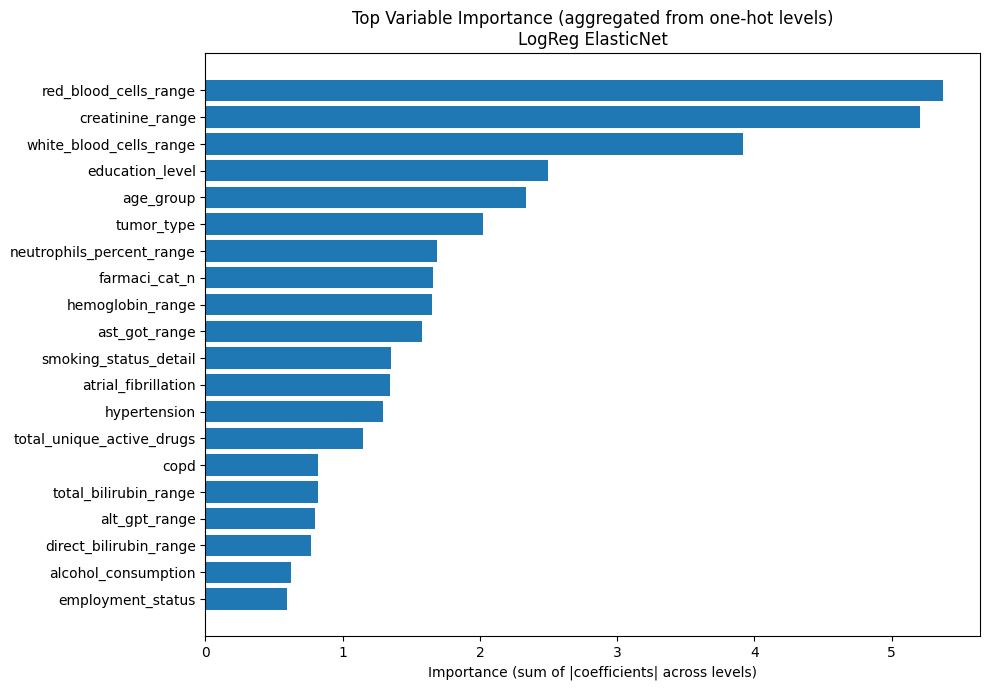

Saved plot: phase5_importance_LogReg_ElasticNet_BY_VARIABLE_top20.png


In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Inputs
# -----------------------------
IMPORTANCE_CSV = r"C:\Users\HP\OneDrive\Desktop\Phase 5\phase5_outputs\phase5_importance_LogReg_ElasticNet.csv"  # your exported file
OUT_VAR_CSV    = r"phase5_importance_LogReg_ElasticNet_BY_VARIABLE.csv"
OUT_VAR_PNG    = r"phase5_importance_LogReg_ElasticNet_BY_VARIABLE_top20.png"

# IMPORTANT: use the exact frozen Phase 5 feature list you trained on
FEATURE_COLS = [
    "age", "age_group", "gender", "ethnicity", "education_level",
    "employment_status", "alcohol_consumption", "smoking_status_detail",
    "tumor_type", "molecular_alterations", "mutations_present", "genotipo_DPYD_type",
    "surgical_intervention", "radiotherapy_status", "received_chemo", "received_targeted_therapy",
    "oncology_treatment_lines_n", "n_treatment_lines", "max_combo_regimen_size",
    "total_chemo_cycles", "treatment_duration_days",
    "hypertension", "dyslipidemia", "ischemic_heart_disease", "atrial_fibrillation",
    "hypertensive_heart_disease", "diabete_tipo_II", "obesity_comorbidity", "copd", "asthma",
    "renal_insufficiency", "anemia_comorbidity", "depressive_syndrome", "psychiatric_disorders",
    "cerebrovascular_disorders", "gastroesophageal_reflux_full", "gastrointestinal_disorders",
    "cardiovascular_disorders",
    "cci_score", "IPB", "farmaci_cat_n", "total_unique_active_drugs",
    "white_blood_cells_range", "red_blood_cells_range", "hemoglobin_range",
    "neutrophils_percent_range", "platelet_count_range", "creatinine_range",
    "ast_got_range", "alt_gpt_range", "total_bilirubin_range", "direct_bilirubin_range",
    "adr_n_tot",
]

# -----------------------------
# 1) Load importance table
# -----------------------------
imp = pd.read_csv(IMPORTANCE_CSV)

# Try to detect column names (so the code doesn't break if you used different headers)
# Common patterns: ["feature","importance"] or ["feature","coef","abs_coef"]
col_feature = None
for c in imp.columns:
    if c.lower() in ["feature", "term", "name", "variable_level"]:
        col_feature = c
        break
if col_feature is None:
    col_feature = imp.columns[0]  # fallback

col_imp = None
for c in imp.columns:
    if c.lower() in ["importance", "abs_importance", "abs_coef", "abs_coefficient", "weight"]:
        col_imp = c
        break
if col_imp is None:
    # fallback: pick the first numeric column
    num_cols = [c for c in imp.columns if pd.api.types.is_numeric_dtype(imp[c])]
    if not num_cols:
        raise ValueError("Could not find an importance numeric column in the CSV.")
    col_imp = num_cols[0]

imp = imp[[col_feature, col_imp]].rename(columns={col_feature: "feature_level", col_imp: "importance"})
imp["importance"] = pd.to_numeric(imp["importance"], errors="coerce").fillna(0.0)

# -----------------------------
# 2) Map one-hot levels -> original variable name
# -----------------------------
# We match by prefix: e.g., "white_blood_cells_range_Low (...)" starts with "white_blood_cells_range_"
# Sort by length so longer names match first (prevents partial prefix issues).
feature_cols_sorted = sorted(FEATURE_COLS, key=len, reverse=True)

def map_to_base_variable(feature_level: str) -> str:
    s = str(feature_level)
    for base in feature_cols_sorted:
        if s == base:
            return base
        if s.startswith(base + "_"):
            return base
    # If no match, keep raw (could be something unexpected)
    return s

imp["variable"] = imp["feature_level"].apply(map_to_base_variable)

# -----------------------------
# 3) Optional: drop Missing/Unknown dummy levels from aggregation
# -----------------------------
# This only removes those specific one-hot terms, not the whole variable.
MISSING_PATTERNS = [
    r"not\s*known", r"missing", r"unknown", r"not\s*noted", r"n/?a", r"null"
]
missing_regex = re.compile("|".join(MISSING_PATTERNS), flags=re.IGNORECASE)

DROP_MISSING_LEVELS = True  # set False if you want them included

if DROP_MISSING_LEVELS:
    keep_mask = ~imp["feature_level"].astype(str).str.contains(missing_regex)
    imp_use = imp[keep_mask].copy()
else:
    imp_use = imp.copy()

# -----------------------------
# 4) Aggregate to variable-level importance
# -----------------------------
# For logistic regression: sum of abs contributions across levels is a good “overall importance”.
var_imp = (
    imp_use
    .groupby("variable", as_index=False)
    .agg(
        importance_sum=("importance", "sum"),
        importance_max=("importance", "max"),
        n_levels=("feature_level", "count")
    )
    .sort_values("importance_sum", ascending=False)
)

# Save
var_imp.to_csv(OUT_VAR_CSV, index=False)
print("Saved variable-level importance:", OUT_VAR_CSV)
print(var_imp.head(15))

# -----------------------------
# 5) Plot Top N variables
# -----------------------------
TOP_N = 20
plot_df = var_imp.head(TOP_N).iloc[::-1]  # reverse for horizontal bar order

plt.figure(figsize=(10, 7))
plt.barh(plot_df["variable"], plot_df["importance_sum"])
plt.title("Top Variable Importance (aggregated from one-hot levels)\nLogReg ElasticNet")
plt.xlabel("Importance (sum of |coefficients| across levels)")
plt.tight_layout()
plt.savefig(OUT_VAR_PNG, dpi=200)
plt.show()

print("Saved plot:", OUT_VAR_PNG)


In [6]:
import joblib
import os
from datetime import datetime

# ============================================================
# 8) Save calibrated VERO model (production artifact)
# ============================================================

ARTIFACT_DIR = "phase5_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

model_path = os.path.join(ARTIFACT_DIR, "vero_model_calibrated.pkl")

joblib.dump(calibrator, model_path)

print(f"Saved calibrated VERO model to: {model_path}")


Saved calibrated VERO model to: phase5_artifacts\vero_model_calibrated.pkl


In [7]:
import json

feature_schema = {
    "feature_columns": FEATURE_COLS,
    "target": TARGET_COL,
    "risk_definition": "Probability of Accelerated Phenotype",
    "vero_score_definition": "round(100 * calibrated_probability)",
    "created_at": datetime.now().isoformat(),
    "best_model": best_name,
    "calibration_method": "isotonic",
}

schema_path = os.path.join(ARTIFACT_DIR, "vero_feature_schema.json")

with open(schema_path, "w") as f:
    json.dump(feature_schema, f, indent=2)

print(f"Saved feature schema to: {schema_path}")


Saved feature schema to: phase5_artifacts\vero_feature_schema.json


In [8]:
loaded_model = joblib.load(model_path)

p_test_reload = loaded_model.predict_proba(X_test)[:, 1]

print("Reloaded model AUC:",
      roc_auc_score(y_test, p_test_reload))


Reloaded model AUC: 0.9521885521885521
